In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load the datasets
items = pd.read_csv("https://raw.githubusercontent.com/Uriel-Gamez98/Data-Science-and-Machine-Learning/refs/heads/main/items.csv")
interactions = pd.read_csv("https://raw.githubusercontent.com/Uriel-Gamez98/Data-Science-and-Machine-Learning/refs/heads/main/interactions_train.csv")
# Display the first rows of each dataset
display(items.head())
display(interactions.head())


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


In [ ]:
# Renaming columns for clarity
interactions.rename(columns={'u': 'user_id'}, inplace=True)
interactions.rename(columns={'i': 'item_id'}, inplace=True)
interactions.rename(columns={'t': 'timestamp'}, inplace=True)
items.rename(columns={'i': 'book_id'}, inplace=True)

# Checking the new columns
display(interactions.head())
display(items.head())

,user_id,item_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [ ]:
n_users = interactions.user_id.nunique()
n_items = interactions.item_id.nunique()
print(f'Number of users = {n_users}, \n Number of items = {n_items} \n Number of interactions = {len(interactions)}')

Number of users = 7838, 
 Number of items = 15109 
 Number of interactions = 87047


In [ ]:
# let's first sort the interactions by user and time stamp
interactions = interactions.sort_values(["user_id", "timestamp"])
interactions.head(10)

,user_id,item_id,timestamp
21035,0,0,1.680191e+09
28842,0,1,1.680783e+09
3958,0,2,1.680801e+09
29592,0,3,1.683715e+09
6371,0,3,1.683715e+09
41220,0,4,1.686569e+09
12217,0,5,1.687014e+09
19703,0,6,1.687014e+09
64522,0,7,1.687014e+09
29380,0,8,1.687260e+09


In [ ]:
interactions["pct_rank"] = interactions.groupby("user_id")["timestamp"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,user_id,item_id,timestamp,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [ ]:
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]
print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 65419
Testing set size: 21628


In [ ]:
print('number of users =', n_users, '| number of items =', n_items)

number of users = 7838 | number of items = 15109


Step 1: Define the Function to Create the Data Matrix

In [ ]:
import numpy as np

# Define a function to create the data matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    # Subtract 1 from item_id values to adjust for 0-based indexing
    # Ensure item_id values are within the valid range
    valid_item_ids = data["item_id"][data["item_id"] <= n_items].values -1
    valid_user_ids = data["user_id"][data["item_id"] <= n_items].values
    data_matrix[valid_user_ids, valid_item_ids] = 1

    return data_matrix

Step 2: Create the Training and Testing Matrices

In [ ]:
# Create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_items)
test_data_matrix = create_data_matrix(test_data, n_users, n_items)

# Display the matrices to understand their structure
print('train_data_matrix')
print(train_data_matrix)
print("number of non-zero values: ", np.sum(train_data_matrix))
print('test_data_matrix')
print(test_data_matrix)
print("number of non-zero values: ", np.sum(test_data_matrix))

train_data_matrix
[[1. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  49490.0
test_data_matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  19306.0


Step 3: Visualize the User-Item Interaction Matrices

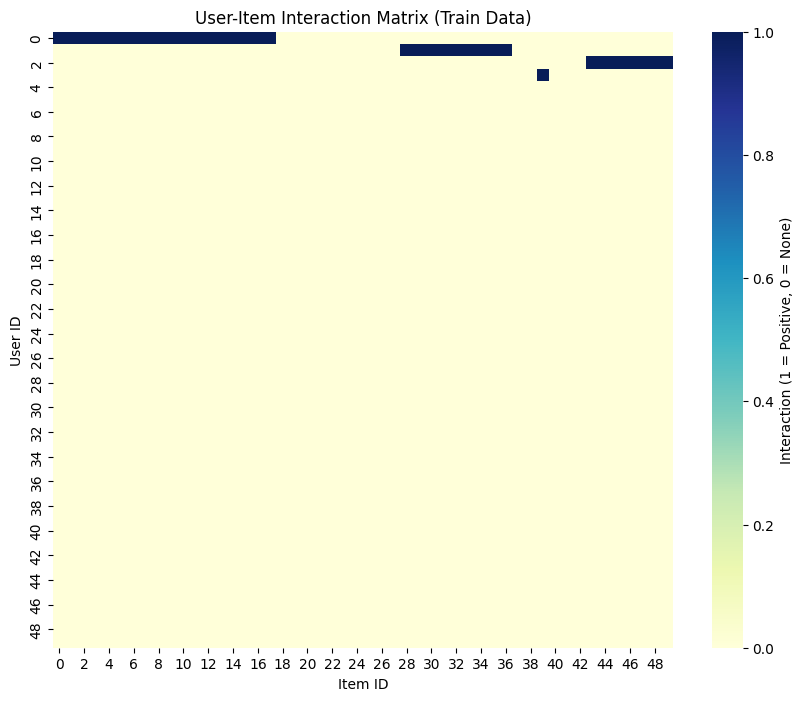

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a heatmap for a subset of the user-item matrix
def plot_interaction_heatmap(data_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item interaction matrix.
    Parameters:
        data_matrix: The matrix to visualize.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization purposes
    matrix_subset = data_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the training and testing matrices
plot_interaction_heatmap(train_data_matrix, 'User-Item Interaction Matrix (Train Data)')

Task 3: Item-to-Item Collaborative Filtering with Implicit Feedback

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the item-item similarity matrix
# Check sklearn documentation for cosine similarity to understand how we are
# using this function.
item_similarity = cosine_similarity(train_data_matrix.T)
print("Item-Item Similarity Matrix:")
print(item_similarity)
print(item_similarity.shape)

Item-Item Similarity Matrix:
[[1.         0.40824829 0.35355339 ... 0.         0.         0.28867513]
 [0.40824829 1.         0.28867513 ... 0.         0.         0.23570226]
 [0.35355339 0.28867513 1.         ... 0.         0.         0.20412415]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.28867513 0.23570226 0.20412415 ... 0.         0.         1.        ]]
(15109, 15109)


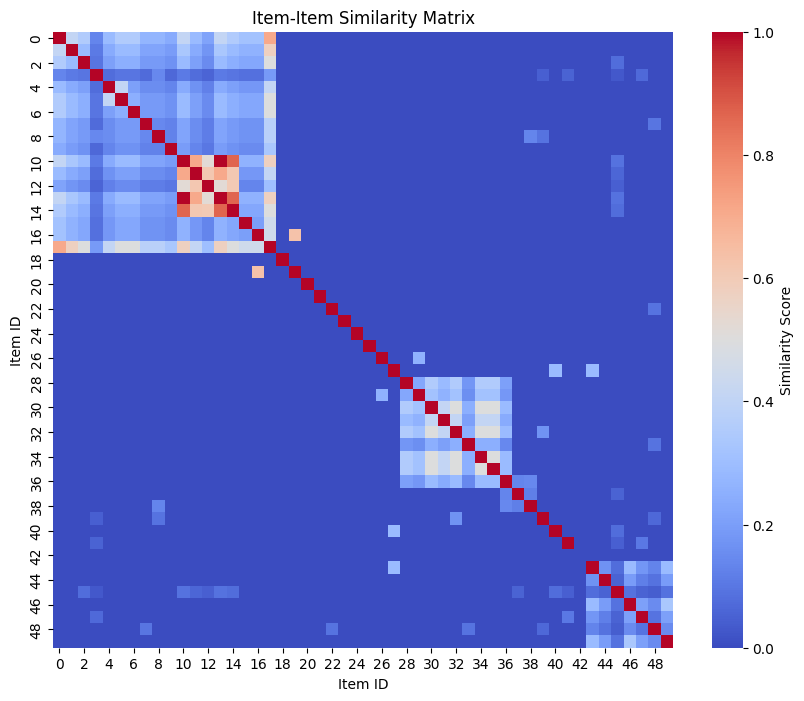

In [ ]:
# Function to visualize the item similarity matrix
def plot_item_similarity_heatmap(similarity_matrix, title, num_items=50):
    """
    Plots a heatmap of a subset of the item similarity matrix.
    Parameters:
        similarity_matrix: The item-item similarity matrix.
        title: The title of the plot.
        num_items: The number of items to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_items, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the item similarity matrix
plot_item_similarity_heatmap(item_similarity, 'Item-Item Similarity Matrix')

In [ ]:
item_similarity[19, 16]

np.float64(0.6324555320336758)

In [ ]:
# Print the item with ID 46
display(items[items['book_id'] == 46])

# Print the item with ID 37
display(items[items['book_id'] == 37])

,Title,Author,ISBN Valid,Publisher,Subjects,book_id
46,Le monde sans fin /,"Jancovici, Jean-Marc",9782205088168; 2205088165,Dargaud,Climate Change; Environmental Health; Environm...,46


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
37,"Simenon, l'Ostrogoth /","Bocquet, José-Louis",9782505120094; 2505120099; 9782505120100; 2505...,Dargaud,"Bandes dessinées; Simenon, Georges",37


Step 2: Predict Positive Interactions Using Item Similarity

In [ ]:
import numpy as np

# Define the function to predict interactions based on item similarity
def item_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on item-item similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The item-item similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # np.dot does the matrix multiplication. Here we are calculating the
    # weighted sum of interactions based on item similarity
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T  # Transpose to get users as rows and items as columns

# Calculate the item-based predictions for positive interactions
item_prediction = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix:")
print(item_prediction)
print(item_prediction.shape)

Predicted Interaction Matrix:
[[0.85222796 0.71537197 0.22943755 ... 0.         0.         0.40256183]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01587346 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15109)


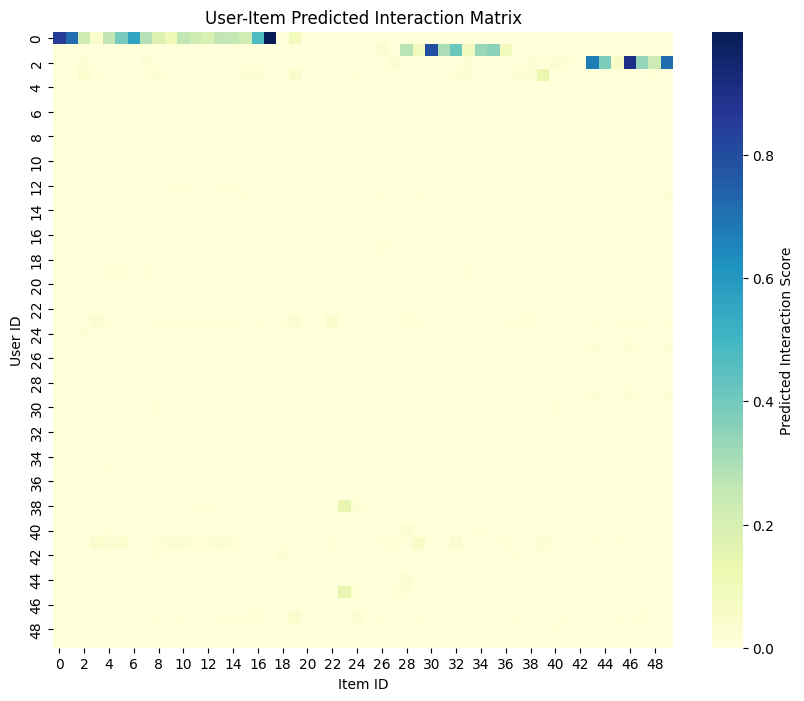

In [ ]:
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(item_prediction, 'User-Item Predicted Interaction Matrix')

Task 4: User-to-User Collaborative Filtering with Implicit Feedback

In [ ]:
# Compute the user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)
print("User-User Similarity Matrix:")
print(user_similarity)

# Check the shape as a sanity check
print("Shape of User Similarity Matrix:", user_similarity.shape)

User-User Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of User Similarity Matrix: (7838, 7838)


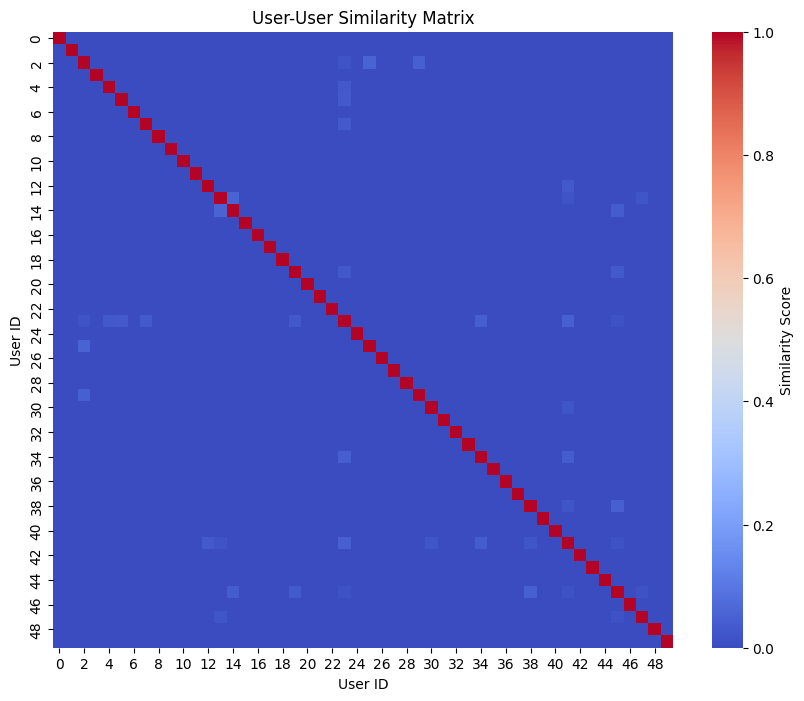

In [ ]:
# Function to plot the user similarity matrix
def plot_user_similarity_heatmap(similarity_matrix, title, num_users=50):
    """
    Plots a heatmap of a subset of the user similarity matrix.
    Parameters:
        similarity_matrix: The user-user similarity matrix.
        title: The title of the plot.
        num_users: The number of users to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_users, :num_users]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the user similarity matrix
plot_user_similarity_heatmap(user_similarity, 'User-User Similarity Matrix')